In [1]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start();

In [2]:
import numpy as np
import torch
import gym
import minerl
import random

from torch import nn
from sklearn.cluster import KMeans
from tqdm import tqdm

class ConvNet(nn.Module):
    """
    :param input_shape: A three-item tuple telling image dimensions in (C, H, W)
    :param output_dim: Dimensionality of the output vector
    """

    def __init__(self, input_shape, output_dim):
        super().__init__()
        n_input_channels = input_shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 32, kernel_size=8, stride=4, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Flatten(),
        )

        # Compute shape by doing one forward pass
        with torch.no_grad():
            n_flatten = self.cnn(torch.zeros(1, *input_shape)).shape[1]

        self.linear = nn.Sequential(
            nn.Linear(n_flatten, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim)
        )

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        return self.linear(self.cnn(observations))

/home/ankitagarg/.local/lib/python3.6/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [3]:
from minerl.data import BufferedBatchIter
DATA_DIR = "/home/ankitagarg/minerl/data/"
EPOCHS = 50
BATCH_SIZE = 32
learning_rate = 1e-4
DATA_SAMPLES = 80000
NUM_ACTION_CENTROIDS = 24

data = minerl.data.make('MineRLTreechopVectorObf-v0', data_dir=DATA_DIR)

In [4]:
all_actions = []

trajectory_names = data.get_trajectory_names()
random.shuffle(trajectory_names)

for trajectory_name in trajectory_names:
    trajectory = data.load_data(trajectory_name, skip_interval=0, include_metadata=False)
    rewards = []
    actions = [] 
    for dataset_observation, dataset_action, dataset_rewards, _, _ in trajectory:
        rewards.append(dataset_rewards)
        actions.append(dataset_action["vector"])
    if sum(rewards) > 0:
        all_actions.extend(actions)
    if len(all_actions) >= DATA_SAMPLES:
        break

all_actions = np.array(all_actions)

# Run k-means clustering using scikit-learn.
print("Running KMeans on the action vectors")
kmeans = KMeans(n_clusters=NUM_ACTION_CENTROIDS)
kmeans.fit(all_actions)
action_centroids = kmeans.cluster_centers_
print("KMeans done")

100%|██████████| 1963/1963 [00:00<00:00, 197099.05it/s]


Running KMeans on the action vectors
KMeans done


In [5]:
# from colabgymrender.recorder import Recorder
env = gym.make('MineRLTreechopVectorObf-v0')
# env = Recorder(env, './video', fps=60)

In [6]:
def test(network, action_centroids, num_episodes):
    
    num_actions = action_centroids.shape[0]
    action_list = np.arange(num_actions)

    episode_rewards = []
    for episode in range(num_episodes):
        obs = env.reset()
        done = False
        total_reward = 0
        steps = 0

        while not done:
            obs = torch.from_numpy(obs['pov'].transpose(2, 0, 1)[None].astype(np.float32) / 255)
            probabilities = torch.softmax(network(obs), dim=1)[0]
            probabilities = probabilities.detach().numpy()
            discrete_action = np.random.choice(action_list, p=probabilities)

            action = action_centroids[discrete_action]
            minerl_action = {"vector": action}

            obs, reward, done, info = env.step(minerl_action)
            total_reward += reward
            steps += 1
            if steps > 18000: 
                break

        episode_rewards.append(total_reward)
    
    return episode_rewards

In [8]:
def train():
    iterator = BufferedBatchIter(data)

    network = ConvNet((3, 64, 64), NUM_ACTION_CENTROIDS)

    optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate)
    loss_function = nn.CrossEntropyLoss()

    iter_count = 0
    losses = []
    training_steps = []
    training_return = []
    for dataset_obs, dataset_actions, _, _, _ in tqdm(iterator.buffered_batch_iter(num_epochs=EPOCHS, batch_size=BATCH_SIZE)):
        obs = dataset_obs["pov"].astype(np.float32)
        obs = obs.transpose(0, 3, 1, 2)
        obs /= 255.0

        action_vector = dataset_actions["vector"]
        distances = np.sum((action_vector - action_centroids[:, None]) ** 2, axis=2)
        actions = np.argmin(distances, axis=0)
        encoded_actions = np.zeros((actions.shape[0],NUM_ACTION_CENTROIDS))
        for i in range(actions.shape[0]):
            encoded_actions[i][actions[i]] = 1

        pred = network(torch.from_numpy(obs).float())
        loss = loss_function(pred, torch.tensor(encoded_actions))
        losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Keep track of how training is going by printing out the loss
        iter_count += 1
        training_steps.append(iter_count)
        
        if (iter_count % 10) == 0:
            mean_loss = sum(losses[-10:]) / 10
            tqdm.write("Iteration {}. Loss {:<10.3f}".format(iter_count, mean_loss))
            
        if (iter_count % 10000) == 0:
            episode_rewards = test(network, action_centroids, 5)
            training_return.append(np.mean(np.array(episode_rewards)))
        
        if(iter_count >= 150000):
            break
        
    # Store the network
    torch.save(network, "behavioural_cloning.pth")
    np.save("behavioural_cloning_centroids.npy", action_centroids)

    return losses, training_steps, training_return

In [9]:
losses, training_steps, training_return = train()

149353it [11:19:30, 166.82it/s]

Iteration 149330. Loss 1.462     
Iteration 149340. Loss 1.528     
Iteration 149350. Loss 1.423     
Iteration 149360. Loss 1.650     
Iteration 149370. Loss 1.491     


149398it [11:19:30, 190.83it/s]

Iteration 149380. Loss 1.382     
Iteration 149390. Loss 1.517     
Iteration 149400. Loss 1.566     



100%|██████████| 1630/1630 [00:00<00:00, 131980.38it/s]
149441it [11:19:30, 142.98it/s]

Iteration 149410. Loss 1.689     
Iteration 149420. Loss 1.473     
Iteration 149430. Loss 1.512     
Iteration 149440. Loss 1.348     
Iteration 149450. Loss 1.545     



100%|██████████| 1452/1452 [00:00<00:00, 101119.59it/s]
149483it [11:19:31, 132.41it/s]

Iteration 149460. Loss 1.437     
Iteration 149470. Loss 1.652     
Iteration 149480. Loss 1.432     
Iteration 149490. Loss 1.584     
Iteration 149500. Loss 1.358     



100%|██████████| 2557/2557 [00:00<00:00, 117064.19it/s]
149544it [11:19:31, 125.10it/s]

Iteration 149510. Loss 1.370     
Iteration 149520. Loss 1.607     
Iteration 149530. Loss 1.675     
Iteration 149540. Loss 1.503     


149564it [11:19:31, 139.90it/s]

Iteration 149550. Loss 1.520     
Iteration 149560. Loss 1.391     
Iteration 149570. Loss 1.576     
Iteration 149580. Loss 1.647     



100%|██████████| 2194/2194 [00:00<00:00, 112127.49it/s]
149625it [11:19:32, 135.71it/s]

Iteration 149590. Loss 1.675     
Iteration 149600. Loss 1.506     
Iteration 149610. Loss 1.521     
Iteration 149620. Loss 1.485     
Iteration 149630. Loss 1.699     


149646it [11:19:32, 151.61it/s]

Iteration 149640. Loss 1.529     
Iteration 149650. Loss 1.556     



100%|██████████| 2215/2215 [00:00<00:00, 10653.97it/s][A
149687it [11:19:33, 98.49it/s] 

Iteration 149660. Loss 1.595     
Iteration 149670. Loss 1.389     
Iteration 149680. Loss 1.576     
Iteration 149690. Loss 1.542     
Iteration 149700. Loss 1.687     


149709it [11:19:33, 118.89it/s]

Iteration 149710. Loss 1.580     
Iteration 149720. Loss 1.574     



100%|██████████| 1669/1669 [00:00<00:00, 105330.93it/s]
149770it [11:19:33, 133.53it/s]

Iteration 149730. Loss 1.617     
Iteration 149740. Loss 1.502     
Iteration 149750. Loss 1.545     
Iteration 149760. Loss 1.683     
Iteration 149770. Loss 1.466     



100%|██████████| 1519/1519 [00:00<00:00, 126288.88it/s]
149808it [11:19:33, 122.42it/s]

Iteration 149780. Loss 1.664     
Iteration 149790. Loss 1.567     
Iteration 149800. Loss 1.640     
Iteration 149810. Loss 1.573     



100%|██████████| 1628/1628 [00:00<00:00, 101503.25it/s]
149846it [11:19:34, 115.29it/s]

Iteration 149820. Loss 1.665     
Iteration 149830. Loss 1.300     
Iteration 149840. Loss 1.550     
Iteration 149850. Loss 1.503     
Iteration 149860. Loss 1.625     


149867it [11:19:34, 133.40it/s]

Iteration 149870. Loss 1.470     



100%|██████████| 3531/3531 [00:00<00:00, 118951.75it/s]
149904it [11:19:35, 94.64it/s] 

Iteration 149880. Loss 1.476     
Iteration 149890. Loss 1.516     
Iteration 149900. Loss 1.444     
Iteration 149910. Loss 1.662     


149944it [11:19:35, 128.87it/s]

Iteration 149920. Loss 1.511     
Iteration 149930. Loss 1.653     
Iteration 149940. Loss 1.496     
Iteration 149950. Loss 1.623     


149963it [11:19:35, 142.06it/s]

Iteration 149960. Loss 1.535     
Iteration 149970. Loss 1.603     
Iteration 149980. Loss 1.506     



100%|██████████| 1961/1961 [00:00<00:00, 90767.97it/s]
149982it [11:19:35, 99.05it/s] 

Iteration 149990. Loss 1.573     
Iteration 150000. Loss 1.574     


149999it [12:08:05,  3.43it/s]


In [18]:
x = []
y = []
for i in range(0,150000,1000): 
    if(i >= len(training_steps)):
        break
    x.append(i)
    y.append(np.mean(np.array(losses[i:i+1000])))
    

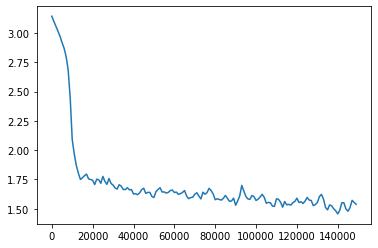

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

loss_plot = sns.lineplot(x=x, y=y)
fig = loss_plot.get_figure()
fig.savefig("training_loss.png")

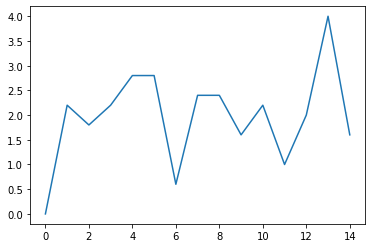

In [20]:
return_plot = sns.lineplot(x=[x for x in range(len(training_return))], y=training_return)
fig = return_plot.get_figure()
fig.savefig("training_return.png")

In [ ]:
action_centroids = np.load("behavioural_cloning_centroids.npy")
network = torch.load("behavioural_cloning.pth")

num_actions = action_centroids.shape[0]
action_list = np.arange(num_actions)

episode_rewards = []
for episode in range(100):
    obs = env.reset()
    done = False
    total_reward = 0
    steps = 0

    while not done:
        obs = torch.from_numpy(obs['pov'].transpose(2, 0, 1)[None].astype(np.float32) / 255)
        probabilities = torch.softmax(network(obs), dim=1)[0]
        probabilities = probabilities.detach().numpy()
        discrete_action = np.random.choice(action_list, p=probabilities)

        action = action_centroids[discrete_action]
        minerl_action = {"vector": action}

        obs, reward, done, info = env.step(minerl_action)
        total_reward += reward
        steps += 1
    
    episode_rewards.append(total_reward)

#     env.release()
#     env.play()
    print(f'Episode #{episode + 1} reward: {total_reward}\t\t episode length: {steps}\n')